In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from pathlib import Path
# !pip install -U finance-datareader
import FinanceDataReader as fdr

In [27]:
df_kospi = fdr.StockListing('KOSPI')

In [28]:
def get_ticker(company_name):
    return str(df_kospi.loc[df_kospi['Name'] == company_name]['Symbol'].values[0])

In [124]:
df_samsung = fdr.DataReader(get_ticker('삼성전자'), '2011-03-01', '2020-02-28')
print(df_samsung.shape)

(2217, 6)


In [125]:
def normalize_close_price(df):
    df = df['Close']
    close_arr = (df.values).reshape(-1, 1)
    normalized_close_arr = (normalize(close_arr, axis=0)).squeeze()
    return normalized_close_arr

In [126]:
arr_samsung = normalize_close_price(df_samsung)
#print(arr_samsung)

In [127]:
def timeseries_for(arr):
    window_size = 20 # Time Window
    time_series = np.float32(np.empty([len(arr) - window_size - 1, window_size + 1]))
    for i in range(len(arr) - window_size - 1):
      time_series[i,:] = arr[i:i + window_size + 1]
    return time_series

In [128]:
time_series_samsung = timeseries_for(arr_samsung)
print(time_series_samsung)

[[0.01114385 0.01120455 0.01147161 ... 0.01111957 0.01111957 0.01124097]
 [0.01120455 0.01147161 0.01099818 ... 0.01111957 0.01124097 0.0113138 ]
 [0.01147161 0.01099818 0.01091321 ... 0.01124097 0.0113138  0.01141092]
 ...
 [0.03568946 0.03587155 0.03471832 ... 0.03593225 0.03447554 0.0351432 ]
 [0.03587155 0.03471832 0.03423275 ... 0.03447554 0.0351432  0.03429345]
 [0.03471832 0.03423275 0.03471832 ... 0.0351432  0.03429345 0.03392927]]


In [129]:
X = time_series_samsung[:, 0:20]
Y = time_series_samsung[:, 20]
print(X.shape, Y.shape)

(2196, 20) (2196,)


In [137]:
trainset_size = 1920
X = time_series_samsung[:trainset_size, 0:20]
Y = time_series_samsung[:trainset_size, 20]

In [138]:
from easydict import EasyDict as edict

args = edict()
args.batch_size = 64
args.nlayers = 2
args.nhid = 20

device = 'cuda:0' if torch.cuda.is_available() and args.gpu else 'cpu'

In [139]:
class StockDataset(Dataset):
    def __init__(self, X_dataset, Y_dataset):
        self.X_dataset = torch.from_numpy(X_dataset).unsqueeze(2).transpose(0, 1)
        self.Y_dataset = torch.from_numpy(Y_dataset)        
    def __len__(self):
        return np.shape(self.Y_dataset)[0]
    def __getitem__(self, idx):        
        sample = {'Sequence': self.X_dataset[:,idx,:], 'Target': self.Y_dataset[idx]}
        return sample

In [140]:
train_dataset = StockDataset(X, Y)
train_dl = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [141]:
class PredictorLSTM(nn.Module):
    def __init__(self):
        super(PredictorLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=args.nhid, num_layers=args.nlayers, batch_first = True)
        self.out = nn.Linear(20,1)
        self.bn = nn.BatchNorm1d(20)
    def forward(self,x, h_state, c_state):
        r_out, (h_state,c_state) = self.lstm(x, (h_state,c_state))    
        r_out = self.bn(r_out)
        outs=[]
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:,time_step,:]))
        return torch.stack(outs,dim=1), (h_state, c_state)

In [142]:
predictor = PredictorLSTM().to(device)

In [144]:
criterion = nn.MSELoss()
optimizer = optim.Adam(predictor.parameters(), lr=0.00005)

In [149]:
def run_training(model):
    h_state = torch.zeros(args.nlayers,args.batch_size,args.nhid).to(device)
    c_state = torch.zeros(args.nlayers,args.batch_size,args.nhid).to(device)
    for epoch in range (100):
        running_loss = 0.0
        prediction_plot=np.empty([trainset_size])
        
        for i, data in enumerate(train_dl):
        # get the inputs
            inputs, labels = data['Sequence'], data['Target']
            x = Variable(inputs).to(device)
            y = Variable(labels).to(device)
            
        # zero the parameter gradients
            optimizer.zero_grad()
            
        # forward + backward + optimize
            prediction, (h_state, c_state) = model(x, h_state,c_state)
            prediction=prediction[:,19,:].squeeze()
            h_state = Variable(h_state.data)
            c_state = Variable(c_state.data)
            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()
            
        # print statistics
            running_loss += loss.item()
            if i % 2 == 1:    # print every 2 mini-batches
                print('Epoch %d Loss %.7f' %(epoch + 1, running_loss / 2))
                running_loss = 0.0
            
            prediction_plot[i * 64:i * 64 + 64] = prediction.cpu().detach().numpy()

    print('Finished Training')
    return prediction_plot

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Loss 0.0001845
Epoch 1 Loss 0.0001201
Epoch 1 Loss 0.0000634
Epoch 1 Loss 0.0000222
Epoch 1 Loss 0.0000282
Epoch 1 Loss 0.0000239
Epoch 1 Loss 0.0000309
Epoch 1 Loss 0.0000110
Epoch 1 Loss 0.0000193
Epoch 1 Loss 0.0000101
Epoch 1 Loss 0.0000125
Epoch 1 Loss 0.0001387
Epoch 1 Loss 0.0003885
Epoch 1 Loss 0.0002996
Epoch 1 Loss 0.0001216
Epoch 2 Loss 0.0001834
Epoch 2 Loss 0.0001215
Epoch 2 Loss 0.0000645
Epoch 2 Loss 0.0000228
Epoch 2 Loss 0.0000288
Epoch 2 Loss 0.0000243
Epoch 2 Loss 0.0000310
Epoch 2 Loss 0.0000110
Epoch 2 Loss 0.0000191
Epoch 2 Loss 0.0000099
Epoch 2 Loss 0.0000129
Epoch 2 Loss 0.0001400
Epoch 2 Loss 0.0003901
Epoch 2 Loss 0.0003002
Epoch 2 Loss 0.0001213
Epoch 3 Loss 0.0001843
Epoch 3 Loss 0.0001227
Epoch 3 Loss 0.0000655
Epoch 3 Loss 0.0000233
Epoch 3 Loss 0.0000292
Epoch 3 Loss 0.0000245
Epoch 3 Loss 0.0000310
Epoch 3 Loss 0.0000109
Epoch 3 Loss 0.0000188
Epoch 3 Loss 0.0000096
Epoch 3 Loss 0.0000133
Epoch 3 Loss 0.0001413
Epoch 3 Loss 0.0003918
Epoch 3 Los

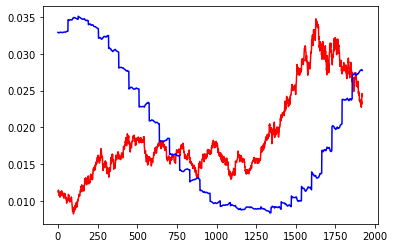

In [150]:
prediction_plot = run_training(predictor)
plt.plot(np.arange(0.0, trainset_size, 1.0), Y, 'r-')
plt.plot(np.arange(0.0, trainset_size, 1.0), np.asarray(prediction_plot), 'b-')
plt.draw()